#### I'm currently working on a project utilizing a Decision Tree Regressor to predict taxi tips. The dataset I'm using is publicly available, sourced from the official NYC government website. This dataset contains valuable information about taxi tips and was collected and provided to the NYC Taxi and Limousine Commission (TLC) by authorized technology providers under the Taxicab & Livery Passenger Enhancement Programs (TPEP/LPEP). Due to its size, the data is stored in Parquet format, and I'm leveraging the PyArrow library to efficiently access and analyze this data.

#### Finaly i will check with sklearn and snapml libraries to compare the performance

In [96]:
# install pyarrow library
# !pip install pyarrow  

import pyarrow.parquet as pq  # import the parquet instance to open the parquet file
raw_data= pq.read_table('yellow_tripdata_2023-09 .parquet') # use .read_table() function to open the parquet file
raw_data = raw_data.to_pandas() 

#### Each row in the dataset represents a taxi trip. As shown above, each row has 18 variables. One variable is called tip_amount and represents the target variable and that is what I am going to predict.

In [97]:
raw_data.shape # Check the size of the dataset

(2846722, 19)

In [99]:
# reduced the size of the dataset
raw_data=raw_data.head(100000)

### Importing libraries

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split as tts
from sklearn.tree import DecisionTreeRegressor as dtr
from sklearn.metrics import roc_auc_score as ras
from snapml import DecisionTreeRegressor as dtrs
from sklearn.metrics import mean_squared_error as mse
import gc
import time
 # to get the time

### Data Cleaning

In [101]:
# If the tip ammunt 0 then it means the tip has been paid in cash so eliminate those rows
raw_data=raw_data[raw_data["tip_amount"] > 0] 

# If the tip amount is larger than the fare cost then eliminate those rows
raw_data = raw_data[raw_data["tip_amount"] <= raw_data["fare_amount"]]

# Eliminate the rows which has the large fare_cost
raw_data = raw_data[((raw_data["fare_amount"] >= 2) & (raw_data["fare_amount"] < 200))]

# Total_amount column include the tip amount so eliminate the total_amount column
clean_data = raw_data.drop(["total_amount"],axis=1)

# here there are two tables that are raw_data and clean_data it will occupied the memry space
# so just remove the raw_data table to avoid the memory out of bond 

del raw_data 

# To reclaim the memory that is no longer in use by the programe so
# we manually call the python's garbage collection process manually
# and we are working with large datasets that generate lots of temporary objects
# we did manualy calling because python's garbage collector might not immediately release
# memory even after object are no longer needed
## forcing the garbage collector to run and freeup the memory that is no longer used

print(gc.collect())

##

6005


### Retrive some statistics about the target variable

In [102]:
print(f"Minimum tip amount is : {np.min(clean_data.tip_amount.values)}")
print(f"Maximum tip amount is : {np.max(clean_data.tip_amount.values)}")

# using .percentile() function to fine the percentile of the data here 90
print(f"90% of the trips have a tip less or equal than : {np.percentile(clean_data.tip_amount.values,90)}")



Minimum tip amount is : 0.01
Maximum tip amount is : 80.0
90% of the trips have a tip less or equal than : 10.79


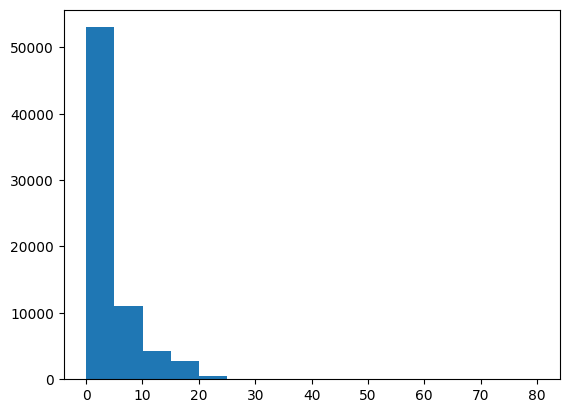

In [103]:
plt.hist(clean_data.tip_amount,16,histtype='bar'); # matplotlib is internally handels the conversion the column in the dataset to an array
                                # or suitable formate to ploting
                                
# Matplotlib has its own internal mechanisms to handle the visualization of data without altering the original dataset.

# plt.hist(clean_data.tip_amount.values)

### Preprocessing

#### In the data set there are 2 columns named as tpep_pickup_datetime and tpep_dropoff_datetime it contains date and time so lets extract date and time seperatly from those columns to easier manipulation and extraction of specific date or time components.

In [104]:
# We change the formate to datetime formate
clean_data["tpep_pickup_datetime"] = pd.to_datetime(clean_data["tpep_pickup_datetime"])
clean_data["tpep_dropoff_datetime"] = pd.to_datetime(clean_data["tpep_dropoff_datetime"])

# extract the time 
clean_data["pickup_hour"]=clean_data["tpep_pickup_datetime"].dt.hour
clean_data["dropoff_hour"]=clean_data["tpep_dropoff_datetime"].dt.hour

# extract the day of week
clean_data["pickup_day"]=clean_data["tpep_pickup_datetime"].dt.weekday
clean_data["dropoff_day"]=clean_data["tpep_dropoff_datetime"].dt.weekday

## compute the trip time in minutes

# calculate the trip time
clean_data["trip_time"]=clean_data["tpep_dropoff_datetime"]-clean_data["tpep_dropoff_datetime"]
# convert it into minutes pd.Timedelta(minutes=1) used here to covert explicitly
clean_data["trip_time"]=clean_data["trip_time"]/pd.Timedelta(minutes=1)

# Now we got the date and Time seperatly so lets eliminate the columns which has the date and time ones

clean_data=clean_data.drop(["tpep_pickup_datetime","tpep_dropoff_datetime"],axis=1)


#### In the clean_data some columns are in the categorical formate to change this into numerical formate (to work with sklearn library) we use the one-hot encoder method from pandas library which will convert and creates binary columns for each category in a categorical feature, where each column represents a single category and contains a 1 if the sample belongs to that category and 0 otherwise

In [105]:
# Retrive the categorical variables
dummy_columns = ["VendorID","RatecodeID","store_and_fwd_flag","PULocationID", "DOLocationID","payment_type", "pickup_hour", "dropoff_hour", "pickup_day", "dropoff_day"]
proc_data = pd.get_dummies(clean_data,columns = dummy_columns)

del clean_data
gc.collect()

45

In [106]:
proc_data.head()

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,...,dropoff_hour_23,pickup_day_2,pickup_day_3,pickup_day_4,pickup_day_5,dropoff_day_2,dropoff_day_3,dropoff_day_4,dropoff_day_5,dropoff_day_6
1,2.0,2.34,14.2,1.0,0.5,2.00,0.0,1.0,2.5,0.00,...,False,False,False,True,False,False,False,True,False,False
2,1.0,1.62,8.6,1.0,0.5,2.00,0.0,1.0,2.5,0.00,...,False,False,False,True,False,False,False,True,False,False
3,1.0,0.74,5.1,1.0,0.5,1.00,0.0,1.0,2.5,0.00,...,False,False,False,True,False,False,False,True,False,False
4,1.0,9.85,45.0,6.0,0.5,17.02,0.0,1.0,2.5,1.75,...,False,False,False,True,False,False,False,True,False,False
6,0.0,10.90,41.5,1.0,0.5,3.00,0.0,1.0,0.0,0.00,...,False,False,False,True,False,False,False,True,False,False


#### Get the feature set(X) and target variable(Y)

In [107]:
first_n_rows = 1000000
proc_data = proc_data.head(first_n_rows)

In [140]:
Y = proc_data["tip_amount"]
proc_data = proc_data.drop(["tip_amount"],axis=1)
Y=Y.values

In [112]:
X = proc_data.values

In [120]:
X = normalize(X,norm='l1',axis=1,copy= False)
# it will do Along each row, the values are divided by the sum of absolute values in that row.
# fThis normalization technique ensures that each row's values sum up to 1, 
# making it a row-wise probability distribution or representing proportions within each row.

#### Split the data for test and train

In [158]:
x_train,x_test,y_train,y_test=tts(X,Y,test_size=0.2,random_state=42)
# tts means train_test_split

### Train a model using sklearn Library

In [159]:
sklearn_model = dtr(max_depth=8,random_state=35)

t0 = time.time()
sklearn_model.fit(x_train,y_train)
sklearn_time= time.time()-t0
print("[Scikit-Learn] Training time (s):  {0:.5f}".format(sklearn_time))



[Scikit-Learn] Training time (s):  8.44945


### Train a model using snapml library

In [160]:
snapml_model = dtrs(max_depth=8, random_state=45, n_jobs=4)

t0 = time.time()
snapml_model.fit(x_train,y_train)
snapml_time= time.time()-t0
print("[Scikit-Learn] Training time (s):  {0:.5f}".format(snapml_time))

[Scikit-Learn] Training time (s):  2.58541


### Evaluate the Scikit-Learn and Snap ML Decision Tree Regressor Models

In [161]:
training_speedup = sklearn_time/snapml_time
print('[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup : {0:.2f}x '.format(training_speedup))


[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup : 3.27x 


In [162]:
### Sklearn
sklearn_pred = sklearn_model.predict(x_test)
sklearn_mse = mse(y_test, sklearn_pred)
print('[Scikit-Learn] MSE score : {0:.3f}'.format(sklearn_mse))

[Scikit-Learn] MSE score : 4.889


In [163]:
### snapml
snapml_pred = snapml_model.predict(x_test)
snapml_mse = mse(y_test, snapml_pred)
print('[Snap ML] MSE score : {0:.3f}'.format(snapml_mse))

[Snap ML] MSE score : 4.817
